Importing and preprocessing our data (preprocess.py)


In [7]:
!pip install tqdm

In [8]:
# mounting
from google.colab import drive

drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [9]:
path = 'Shareddrive/Sea Slugs/DL DATA'
!pwd



/Users/justinhickey/Documents/Deep Learning/CSCI1470_FinalProject/code


/job:localhost/replica:0/task:0/device:GPU:0
Found 1384 files belonging to 2 classes.
Using 1108 files for training.
break
Found 1384 files belonging to 2 classes.
Using 276 files for validation.
break
Found 60 files belonging to 2 classes.
['Fractured', 'Non_fractured']
['Fractured', 'Non_fractured']


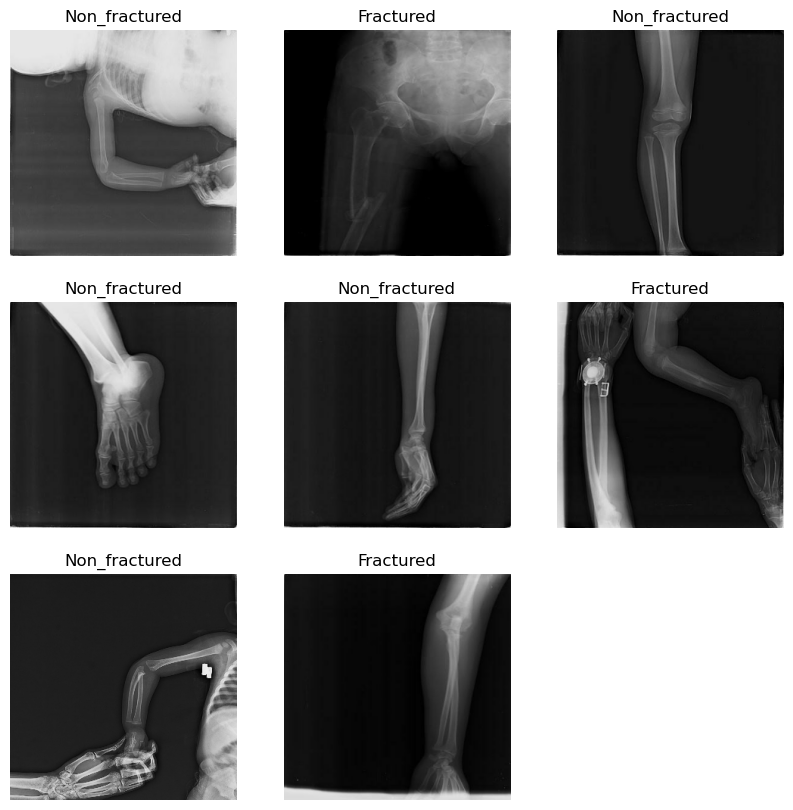

In [8]:
## import statements
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "2"  # Suppress TensorFlow info and warning messages
)
os.environ["TF_METAL_DEVICE_PLACEMENT_VERBOSE"] = "0"

import tensorflow as tf


# initialzing our variables
data_folder_train = "../data/fract_atlas"
data_folder_test = "../data/test_fract_atlas"
data_folder_val = "../data/orig_val"
output_size = (300, 300)  # resizing our fracture images to 224x224

tensor = tf.constant([])
print(tensor.device)



train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder_train,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=output_size,
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
)
print("break")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder_train,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=output_size,
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
)
print("break")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder_test,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=output_size,
)
print(train_dataset.class_names)
print(val_dataset.class_names)


import matplotlib.pyplot as plt

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Run the script below when first using frac atlas data as we need to convert to RGB and get rid of corrupted images.


In [31]:
from os import listdir

path = "../data/fract_atlas/Non_Fractured/"
dir = listdir(path)

# 
for file in dir:
    file_name = path + file
    try:

        img = Image.open(file_name)
        rgb_im = img.convert("RGB")
        rgb_im.save(file_name)

    except Exception as e:
        print(f"Error loading image {file}: {e}")
        os.remove(file_name)

In [11]:
!pip install scikit-image


Model Architecture:

We are going to start with VGG16-pretrained model to start


In [21]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Would remove:
    /Users/justinhickey/anaconda3/envs/csci1470/lib/python3.10/site-packages/tensorflow-2.13.0.dist-info/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [23]:
!pip install tensorflow-gpu==2.8.3

python(36660) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.8.3 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.8.3


In [2]:
# CNN imports

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image  ## Python Image Library. Very Useful

from tqdm import tqdm  ## For nice progress bars


In [3]:
# only run this once (from Lab)

if "vgg_model" not in globals():  ## Don't download it again
    vgg_model = tf.keras.applications.vgg16.VGG16(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
    )

In [4]:
##
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now time to instantiate our VGG16 model


In [22]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming your preprocessed images are stored in 'images_train', 'labels_train', 'images_val', and 'labels_val'
# and are already loaded into memory

# 1. Load the VGG16 model without the top layer (classification layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))

print(tf.config.list_physical_devices("GPU"))

# 2. Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Add your classification layers
model = Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(300, 300, 3)),
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomFlip("vertical"),
        base_model,
        Flatten(),
        Dense(4096, activation="leaky_relu"),
        Dense(2048, activation="leaky_relu"),
        Dense(1024, activation="leaky_relu"),
        Dense(512),
        Dense(1, activation="sigmoid"),  # Binary classification
    ]
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)




print("About to train the model")
# Train the model
history = model.fit(
    train_dataset,
    # Adjust based on your dataset size and available memory
    epochs=10,  # Adjust based on your needs
    validation_data=val_dataset,
)

print("Model has been saved")
# Save the model
model.save("my_vgg16_model.keras")

# 7. Evaluate the model
# Evaluate your model using model.evaluate() on your test set

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


About to train the model
Epoch 1/10
35/35 [==============================] - 119s 3s/step - loss: 0.9896 - accuracy: 0.5379 - auc_5: 0.5517 - precision_5: 0.5386 - recall_5: 0.5753 - val_loss: 0.7789 - val_accuracy: 0.4855 - val_auc_5: 0.7555 - val_precision_5: 1.0000 - val_recall_5: 0.0139
Epoch 2/10
35/35 [==============================] - 85s 2s/step - loss: 0.6128 - accuracy: 0.6552 - auc_5: 0.7219 - precision_5: 0.6507 - recall_5: 0.6810 - val_loss: 0.5867 - val_accuracy: 0.6594 - val_auc_5: 0.7844 - val_precision_5: 0.6190 - val_recall_5: 0.9028
Epoch 3/10
35/35 [==============================] - 75s 2s/step - loss: 0.5946 - accuracy: 0.6850 - auc_5: 0.7501 - precision_5: 0.6774 - recall_5: 0.7151 - val_loss: 0.5886 - val_accuracy: 0.6739 - val_auc_5: 0.7946 - val_precision_5: 0.8214 - val_recall_5: 0.4792
Epoch 4/10
35/35 [==============================] - 70s 2s/step - loss: 0.5379 - accuracy: 0.7283 - auc_5: 0.8079 - precision_5: 0.7282 - recall_5: 0.7348 - val_loss: 0.5483 - 

dict_keys(['loss', 'accuracy', 'auc_5', 'precision_5', 'recall_5', 'val_loss', 'val_accuracy', 'val_auc_5', 'val_precision_5', 'val_recall_5'])


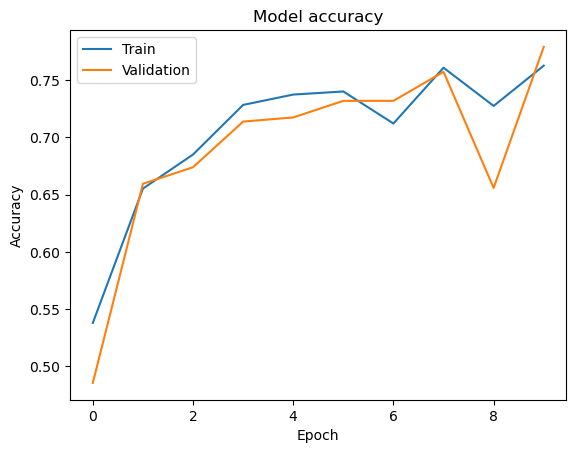

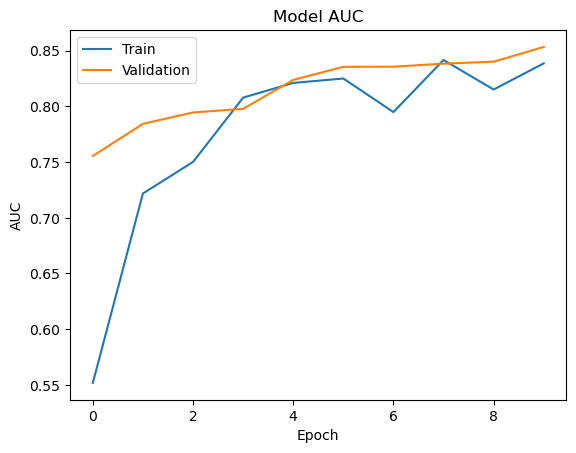

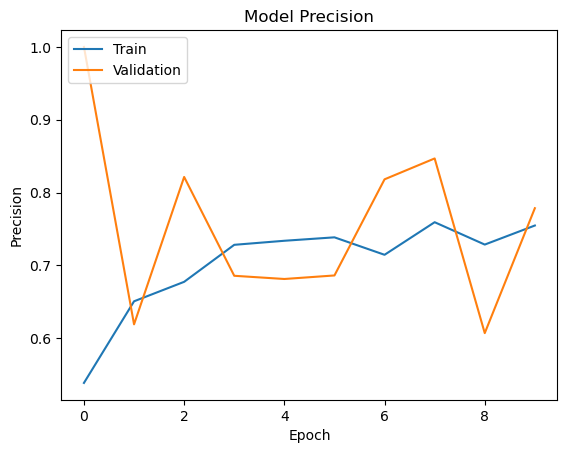

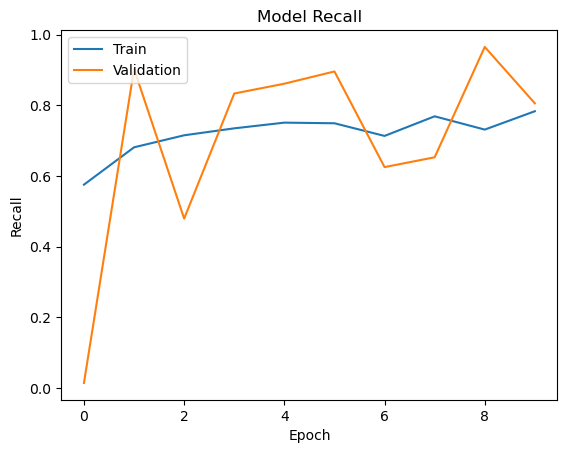

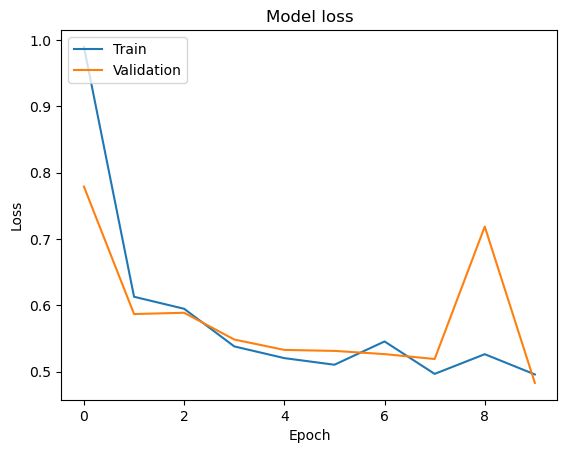

In [24]:
# may need to change keys!

#accuracy
print(history.history.keys())
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#auc
plt.plot(history.history["auc_5"])
plt.plot(history.history["val_auc_5"])
plt.title("Model AUC")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#precision
plt.plot(history.history["precision_5"])
plt.plot(history.history["val_precision_5"])
plt.title("Model Precision")
plt.ylabel("Precision")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#recall
plt.plot(history.history["recall_5"])
plt.plot(history.history["val_recall_5"])
plt.title("Model Recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [25]:

print("Evaluate on test data")
results = model.evaluate(test_dataset)
print(f"test loss, test acc: {results}")

Evaluate on test data
2/2 [==============================] - 8s 2s/step - loss: 0.3197 - accuracy: 0.9167 - auc_5: 0.9767 - precision_5: 0.9310 - recall_5: 0.9000
test loss, test acc: [0.3197327256202698, 0.9166666865348816, 0.9766666293144226, 0.931034505367279, 0.8999999761581421]
